# TP3 - Modelado y prototipo de estimación de tarifas aéreas

## 1. Introducción
En este cuaderno desarrollamos el flujo completo para estimar la tarifa de vuelos domésticos en India. Trabajamos con el archivo `dataset/Cleaned_dataset.csv`, definimos el problema como una regresión supervisada y avanzamos con preparación de datos, entrenamiento de modelos y desarrollo de un prototipo funcional.

Desde el punto de vista de negocio, el modelo apunta a responder preguntas como: *¿este vuelo está caro o barato respecto a vuelos similares?* y *¿cómo cambia el precio esperado si modifico aerolínea, cantidad de escalas o días de anticipación?*. Este tipo de herramienta podría utilizarse tanto por un usuario final (comparar alternativas de compra) como por una aerolínea o agencia online para entender la sensibilidad del precio frente a distintas decisiones comerciales.


In [1]:
import warnings
from pathlib import Path

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from xgboost import XGBRegressor

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV, cross_validate,
                                     train_test_split)
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

warnings.filterwarnings("ignore", category=UserWarning)
sns.set_theme(style="whitegrid", context="talk")

### 1.1 Configuración inicial

In [2]:
DATA_PATH = Path("dataset/Cleaned_dataset.csv")
ARTIFACTS_DIR = Path("artifacts")
RANDOM_STATE = 42

ARTIFACTS_DIR.mkdir(exist_ok=True)
pd.set_option("display.max_columns", None)

### 1.2 Carga del dataset

In [3]:
df_raw = pd.read_csv(DATA_PATH)
df = df_raw.copy()
print(f"Registros totales: {df.shape[0]:,} | Columnas: {df.shape[1]}")
df.head()

Registros totales: 452,088 | Columnas: 13


,Date_of_journey,Journey_day,Airline,Flight_code,Class,Source,Departure,Total_stops,Arrival,Destination,Duration_in_hours,Days_left,Fare
0,2023-01-16,Monday,SpiceJet,SG-8169,Economy,Delhi,After 6 PM,non-stop,After 6 PM,Mumbai,2.0833,1,5335
1,2023-01-16,Monday,Indigo,6E-2519,Economy,Delhi,After 6 PM,non-stop,Before 6 AM,Mumbai,2.3333,1,5899
2,2023-01-16,Monday,GO FIRST,G8-354,Economy,Delhi,After 6 PM,non-stop,Before 6 AM,Mumbai,2.1667,1,5801
3,2023-01-16,Monday,SpiceJet,SG-8709,Economy,Delhi,After 6 PM,non-stop,After 6 PM,Mumbai,2.0833,1,5794
4,2023-01-16,Monday,Air India,AI-805,Economy,Delhi,After 6 PM,non-stop,After 6 PM,Mumbai,2.1667,1,5955


### 1.3 Exploración general

In [4]:
df.info()

df.select_dtypes(include=np.number).describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452088 entries, 0 to 452087
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Date_of_journey    452088 non-null  object 
 1   Journey_day        452088 non-null  object 
 2   Airline            452088 non-null  object 
 3   Flight_code        452088 non-null  object 
 4   Class              452088 non-null  object 
 5   Source             452088 non-null  object 
 6   Departure          452088 non-null  object 
 7   Total_stops        452088 non-null  object 
 8   Arrival            452088 non-null  object 
 9   Destination        452088 non-null  object 
 10  Duration_in_hours  452088 non-null  float64
 11  Days_left          452088 non-null  int64  
 12  Fare               452088 non-null  int64  
dtypes: float64(1), int64(2), object(10)
memory usage: 44.8+ MB


,count,mean,std,min,25%,50%,75%,max
Duration_in_hours,452088.0,12.349222,7.431478,0.75,6.5833,11.3333,16.5,43.5833
Days_left,452088.0,25.627902,14.300846,1.00,13.0000,26.0000,38.0,50.0000
Fare,452088.0,22840.100890,20307.963002,1307.00,8762.7500,13407.0000,35587.0,143019.0000


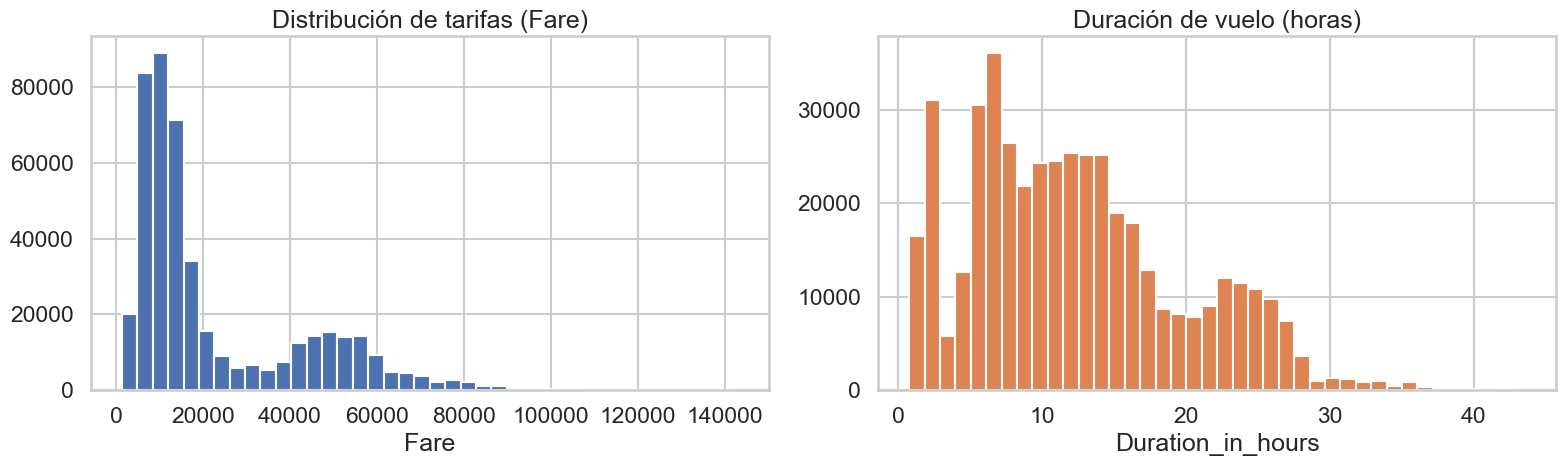

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
axes[0].hist(df["Fare"], bins=40, color="#4c72b0")
axes[0].set_title("Distribución de tarifas (Fare)")
axes[0].set_xlabel("Fare")
axes[1].hist(df["Duration_in_hours"], bins=40, color="#dd8452")
axes[1].set_title("Duración de vuelo (horas)")
axes[1].set_xlabel("Duration_in_hours")
plt.tight_layout()
plt.show()

In [6]:
cat_cols = ["Airline", "Source", "Destination", "Total_stops", "Class"]
for col in cat_cols:
    display(pd.DataFrame({"categoria": df[col].value_counts().index,
                          "frecuencia": df[col].value_counts().values}).head(10))

,categoria,frecuencia
0,Vistara,231490
1,Air India,119841
2,Indigo,65659
3,AirAsia,15764
4,GO FIRST,10786
5,SpiceJet,5863
6,AkasaAir,2230
7,AllianceAir,393
8,StarAir,62


,categoria,frecuencia
0,Delhi,83153
1,Mumbai,80723
2,Bangalore,73375
3,Hyderabad,56657
4,Chennai,56514
5,Kolkata,55560
6,Ahmedabad,46106


,categoria,frecuencia
0,Mumbai,82995
1,Delhi,77739
2,Bangalore,72344
3,Hyderabad,62539
4,Chennai,57589
5,Kolkata,54447
6,Ahmedabad,44435


,categoria,frecuencia
0,1-stop,369650
1,non-stop,51755
2,2+-stop,30683


,categoria,frecuencia
0,Economy,252033
1,Business,126834
2,Premium Economy,73077
3,First,144


> Observamos una concentración de vuelos con origen Delhi/Mumbai, presencia de múltiples aerolíneas y predominio de rutas sin escalas. Las tarifas muestran una distribución sesgada a la derecha, lo que sugiere la conveniencia de usar métricas robustas como MAE para evaluar el rendimiento de los modelos.

### 1.4 Calidad de datos

In [7]:
df.isnull().sum()

Date_of_journey      0
Journey_day          0
Airline              0
Flight_code          0
Class                0
Source               0
Departure            0
Total_stops          0
Arrival              0
Destination          0
Duration_in_hours    0
Days_left            0
Fare                 0
dtype: int64

In [8]:
duplicate_cols = [
    "Date_of_journey", "Airline", "Flight_code", "Source",
    "Destination", "Departure", "Arrival", "Class"
]
duplicated_rows = df.duplicated(subset=duplicate_cols).sum()
print(f"Duplicados detectados: {duplicated_rows}")
df = df.drop_duplicates(subset=duplicate_cols).reset_index(drop=True)
print(f"Dataset tras remover duplicados: {df.shape}")

Duplicados detectados: 134600
Dataset tras remover duplicados: (317488, 13)


Percentiles 1% y 99%:
          Fare  Duration_in_hours  Days_left
0.01   2605.0             1.2500        1.0
0.99  78513.0            28.0833       50.0


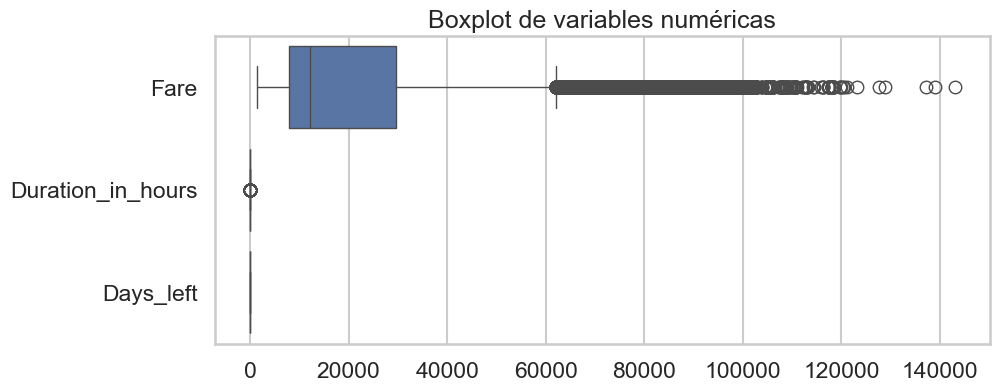

In [9]:
numeric_cols = ["Fare", "Duration_in_hours", "Days_left"]

quantiles = df[numeric_cols].quantile([0.01, 0.99])

print("Percentiles 1% y 99%:\n", quantiles)

plt.figure(figsize=(10, 4))

sns.boxplot(data=df[numeric_cols], orient="h")

plt.title("Boxplot de variables numéricas")

plt.show()

Los outliers son esperables por tratarse de tarifas aéreas y duraciones variables según la ruta. No los eliminaremos para conservar la variabilidad, pero los tendremos presentes cuando evaluemos los errores.

### 1.5 Feature engineering y preprocesamiento

In [10]:
DEPARTURE_ORDER = {
    "Before 6 AM": 0,
    "6 AM - 12 PM": 1,
    "12 PM - 6 PM": 2,
    "After 6 PM": 3
}
ARRIVAL_ORDER = DEPARTURE_ORDER.copy()
JOURNEY_DAY_MAP = {
    "Monday": 0,
    "Tuesday": 1,
    "Wednesday": 2,
    "Thursday": 3,
    "Friday": 4,
    "Saturday": 5,
    "Sunday": 6
}


def _parse_total_stops(value):
    if pd.isna(value):
        return np.nan
    value = str(value).lower().strip()
    if "non" in value:
        return 0
    digits = ''.join(ch for ch in value if ch.isdigit())
    return float(digits) if digits else np.nan


class FeatureGenerator(BaseEstimator, TransformerMixin):
    '''Genera variables derivadas manteniendo el esquema del dataset original.'''

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        df_feat = X.copy()
        if "Date_of_journey" in df_feat.columns:
            dates = pd.to_datetime(df_feat["Date_of_journey"], errors="coerce")
            df_feat["month"] = dates.dt.month
            df_feat["journey_weekday"] = dates.dt.weekday
            df_feat["is_weekend"] = (dates.dt.weekday >= 5).astype(int)
        else:
            df_feat["month"] = np.nan
            df_feat["journey_weekday"] = np.nan
            df_feat["is_weekend"] = np.nan

        if "Journey_day" in df_feat.columns:
            weekday_from_text = df_feat["Journey_day"].map(JOURNEY_DAY_MAP)
            df_feat["journey_weekday"] = df_feat["journey_weekday"].fillna(weekday_from_text)
            df_feat["is_weekend"] = df_feat["is_weekend"].fillna((weekday_from_text >= 5).astype(float))

        df_feat["departure_code"] = df_feat["Departure"].map(DEPARTURE_ORDER)
        df_feat["arrival_code"] = df_feat["Arrival"].map(ARRIVAL_ORDER)

        df_feat["total_stops_num"] = df_feat["Total_stops"].apply(_parse_total_stops)
        df_feat["is_nonstop"] = (df_feat["total_stops_num"] == 0).astype(int)

        df_feat["Duration_in_hours"] = pd.to_numeric(df_feat["Duration_in_hours"], errors="coerce")
        df_feat["Days_left"] = pd.to_numeric(df_feat["Days_left"], errors="coerce")
        df_feat["duration_per_stop"] = df_feat["Duration_in_hours"] / (df_feat["total_stops_num"] + 1)

        df_feat["is_last_minute"] = (df_feat["Days_left"] <= 3).astype(int)
        df_feat["is_early_booking"] = (df_feat["Days_left"] >= 60).astype(int)

        df_feat["route"] = (
            df_feat["Source"].fillna("Desconocido")
            + "-"
            + df_feat["Destination"].fillna("Desconocido")
        )

        return df_feat


numeric_features = [
    "Duration_in_hours",
    "Days_left",
    "month",
    "journey_weekday",
    "departure_code",
    "arrival_code",
    "total_stops_num",
    "duration_per_stop",
    "is_weekend",
    "is_nonstop",
    "is_last_minute",
    "is_early_booking"
]

categorical_features = ["Airline", "Class", "Source", "Destination", "route"]


def build_preprocessor():
    numeric_pipeline = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]
    )
    categorical_pipeline = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("encoder", OneHotEncoder(handle_unknown="ignore"))
        ]
    )
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_pipeline, numeric_features),
            ("cat", categorical_pipeline, categorical_features)
        ]
    )
    return preprocessor


def build_pipeline(model):
    return Pipeline(
        steps=[
            ("feature_gen", FeatureGenerator()),
            ("preprocessor", build_preprocessor()),
            ("model", model)
        ]
    )

### 1.6 División en train/test

In [11]:
TARGET = "Fare"
X = df.drop(columns=[TARGET])
y = df[TARGET]

try:
    stratify_labels = pd.qcut(y, q=10, labels=False, duplicates="drop")
except ValueError:
    stratify_labels = None

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=stratify_labels
)

X_train.shape, X_test.shape

((253990, 12), (63498, 12))

### 1.7 Métricas auxiliares

In [12]:
def regression_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    return {
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2
    }

### 1.8 Modelos baseline

In [13]:
baseline_models = {
    "Dummy (mediana)": DummyRegressor(strategy="median"),
    "Regresión Ridge": Ridge(alpha=1.0)
}

baseline_results = []
trained_baselines = {}
for name, estimator in baseline_models.items():
    pipeline = build_pipeline(estimator)
    pipeline.fit(X_train, y_train)
    preds = pipeline.predict(X_test)
    metrics = regression_metrics(y_test, preds)
    metrics["modelo"] = name
    baseline_results.append(metrics)
    trained_baselines[name] = pipeline

baseline_df = pd.DataFrame(baseline_results)
baseline_df[["modelo", "MAE", "RMSE", "R2"]]

/Users/tmmymrtnz/docs/cda/.venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/tmmymrtnz/docs/cda/.venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


,modelo,MAE,RMSE,R2
0,Dummy (mediana),12994.228070,20973.746346,-0.210199
1,Regresión Ridge,4784.561761,7229.118435,0.856228


### 1.9 Modelos avanzados y validación cruzada

In [14]:
advanced_models = [
    ("Random Forest", RandomForestRegressor(
        n_estimators=80,
        max_depth=None,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )),
    ("XGBoost", XGBRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=8,
        subsample=0.9,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        random_state=RANDOM_STATE,
        tree_method="hist"
    )),
]

scoring = {
    "mae": "neg_mean_absolute_error",
    "rmse": "neg_root_mean_squared_error",
    "r2": "r2"
}

# Para acelerar, comparamos modelos sobre una muestra del train
X_sample = X_train.sample(min(5000, len(X_train)), random_state=RANDOM_STATE)
y_sample = y_train.loc[X_sample.index]

cv_summary = []
for name, estimator in advanced_models:
    pipeline = build_pipeline(estimator)
    cv_scores = cross_validate(
        pipeline,
        X_sample,
        y_sample,
        scoring=scoring,
        cv=3,
        n_jobs=-1,
        error_score="raise"
    )
    cv_summary.append({
        "modelo": name,
        "MAE (CV)": -cv_scores["test_mae"].mean(),
        "RMSE (CV)": -cv_scores["test_rmse"].mean(),
        "R2 (CV)": cv_scores["test_r2"].mean()
    })

cv_results_df = pd.DataFrame(cv_summary)
cv_results_df


,modelo,MAE (CV),RMSE (CV),R2 (CV)
0,Random Forest,3410.126344,5863.025491,0.901290
1,XGBoost,3328.486978,5734.232546,0.905615


### 1.10 Búsqueda de hiperparámetros

In [15]:
# Seleccionamos el mejor modelo según MAE (CV) y construimos un Random Forest sencillo
best_row = cv_results_df.sort_values('MAE (CV)').iloc[0]
print('Mejor modelo según CV:', best_row['modelo'])

best_model = build_pipeline(RandomForestRegressor(
    n_estimators=80,
    max_depth=None,
    random_state=RANDOM_STATE,
    n_jobs=-1
))


Mejor modelo según CV: XGBoost


### 1.11 Evaluación en el conjunto de test

In [16]:
best_model.fit(X_train, y_train)
test_predictions = best_model.predict(X_test)
final_metrics = regression_metrics(y_test, test_predictions)
final_metrics

/Users/tmmymrtnz/docs/cda/.venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'MAE': 1907.5773649005864,
 'RMSE': 3951.3756318593996,
 'R2': 0.9570462034525288}

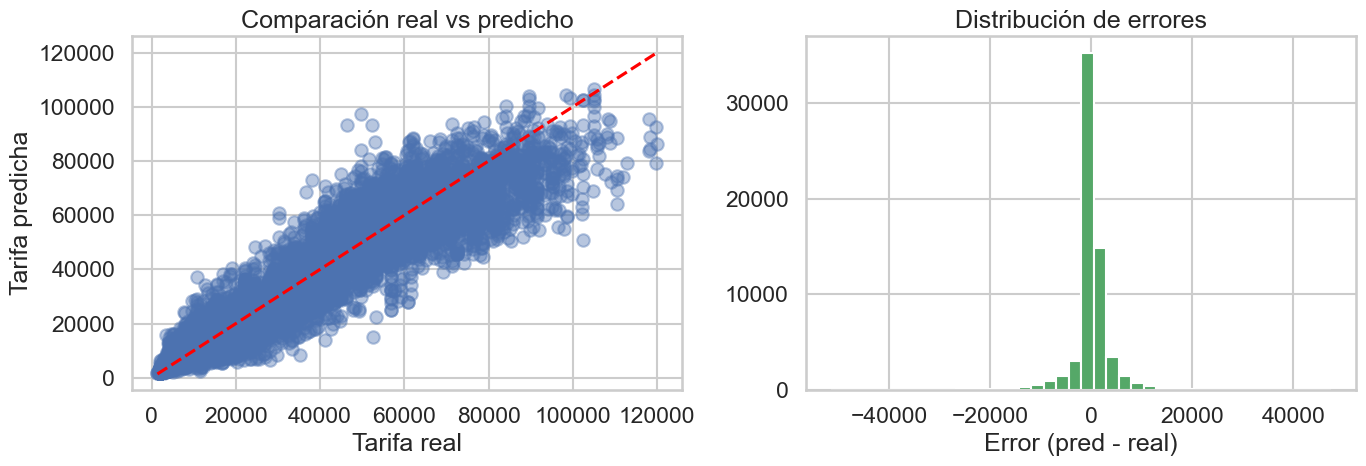

In [17]:
evaluation_df = pd.DataFrame({
    "real": y_test,
    "prediccion": test_predictions
})
evaluation_df["error"] = evaluation_df["prediccion"] - evaluation_df["real"]
evaluation_df["abs_error"] = evaluation_df["error"].abs()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].scatter(evaluation_df["real"], evaluation_df["prediccion"], alpha=0.4)
axes[0].plot([evaluation_df["real"].min(), evaluation_df["real"].max()],
             [evaluation_df["real"].min(), evaluation_df["real"].max()],
             color="red", linestyle="--")
axes[0].set_xlabel("Tarifa real")
axes[0].set_ylabel("Tarifa predicha")
axes[0].set_title("Comparación real vs predicho")
axes[1].hist(evaluation_df["error"], bins=40, color="#55a868")
axes[1].set_title("Distribución de errores")
axes[1].set_xlabel("Error (pred - real)")
plt.tight_layout()
plt.show()

### 1.12 Análisis de errores e importancia de variables

In [18]:
feature_view = FeatureGenerator().transform(X_test)

error_analysis_df = pd.concat([feature_view.reset_index(drop=True), evaluation_df.reset_index(drop=True)], axis=1)

error_by_route = error_analysis_df.groupby("route")["abs_error"].mean().sort_values(ascending=False).head(10)
error_by_stops = error_analysis_df.groupby("is_nonstop")["abs_error"].mean()

print("Error medio por rutas más difíciles:\n", error_by_route)
print("Error medio por tipo de vuelo (0 = con escalas, 1 = directo):\n", error_by_stops)

Error medio por rutas más difíciles:
 route
Kolkata-Ahmedabad      2894.991215
Ahmedabad-Chennai      2821.346696
Bangalore-Ahmedabad    2737.305672
Ahmedabad-Bangalore    2403.500914
Mumbai-Ahmedabad       2369.227795
Ahmedabad-Mumbai       2350.456985
Ahmedabad-Kolkata      2303.809094
Mumbai-Hyderabad       2288.306047
Hyderabad-Ahmedabad    2231.823351
Ahmedabad-Hyderabad    2231.050157
Name: abs_error, dtype: float64
Error medio por tipo de vuelo (0 = con escalas, 1 = directo):
 is_nonstop
0    2064.756759
1    1086.460623
Name: abs_error, dtype: float64


/var/folders/7p/rws7_cn114j6khnyqkn98kpm0000gn/T/ipykernel_22406/1465273902.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x="importance", y="feature", palette="viridis")


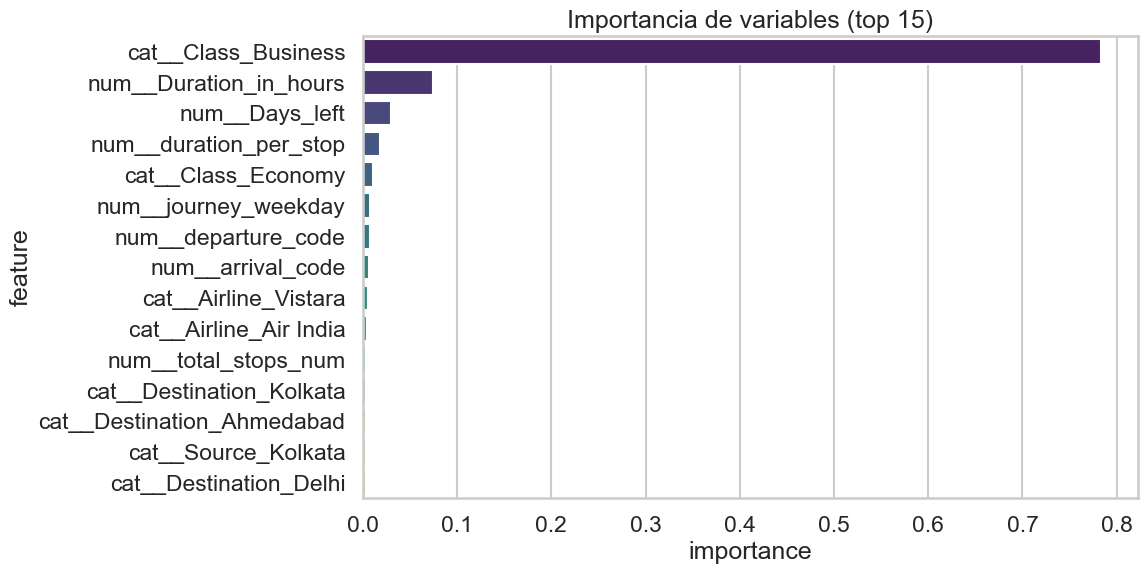

In [19]:
model_step = best_model.named_steps.get("model")
preprocessor_step = best_model.named_steps.get("preprocessor")

if hasattr(model_step, "feature_importances_"):
    feature_names = preprocessor_step.get_feature_names_out()
    importances = model_step.feature_importances_
    importance_df = pd.DataFrame({
        "feature": feature_names,
        "importance": importances
    }).sort_values(by="importance", ascending=False).head(15)
    plt.figure(figsize=(10, 6))
    sns.barplot(data=importance_df, x="importance", y="feature", palette="viridis")
    plt.title("Importancia de variables (top 15)")
    plt.show()
else:
    print("El modelo seleccionado no expone importancias de forma nativa.")

### 1.14 Guardado del modelo para despliegue

In [20]:
MODEL_PATH = ARTIFACTS_DIR / "model_pipeline.joblib"
joblib.dump(best_model, MODEL_PATH)
print(f"Pipeline completo guardado en: {MODEL_PATH}")

Pipeline completo guardado en: artifacts/model_pipeline.joblib


### 1.15 Propuesta de despliegue
- **App Streamlit**: desplegar la aplicación como un único servicio que carga el modelo entrenado desde `artifacts/model_pipeline.joblib` y expone la interfaz interactiva de predicción, what-if y análisis del dataset. En un entorno real podría publicarse en una plataforma tipo Streamlit Cloud o detrás de un servidor web.
- **API opcional**: en una evolución futura, el mismo pipeline podría exponerse a través de una API REST (por ejemplo FastAPI) consumida por otras aplicaciones (web, móvil, dashboards). La lógica actual de predicción es compatible con ese esquema.
- **Operación y MLOps**: se recomienda separar el flujo de entrenamiento del de inferencia. El entrenamiento podría ejecutarse de forma periódica (por ejemplo mensual) con nuevos datos, evaluando siempre el rendimiento (MAE/RMSE) sobre un conjunto de validación temporal antes de promover un nuevo modelo a producción.
- **Monitoreo**: en producción conviene monitorear el MAE por ruta, la distribución de `Days_left` y de `Fare`, y alertar si se observa drift significativo respecto al dataset de entrenamiento. También es útil versionar modelos (por ejemplo `model_v1`, `model_v2`, etc.) para poder comparar y revertir si una versión nueva degrada el rendimiento.


- **API FastAPI**: levantar un servicio que cargue `artifacts/model_pipeline.joblib` y exponga `POST /predict` para recibir las características del vuelo y devolver la tarifa estimada (más un intervalo de confianza aproximado).
- **Frontend Streamlit**: interfaz simple para que una persona ingrese aerolínea, ruta, franjas horarias, escalas, días de anticipación y duración estimada. El frontend llama a la API y muestra el resultado junto con comparaciones históricas.
- **Operación**: el modelo se podría re-entrenar semanal o mensualmente cuando haya nuevos datos. Se recomienda empaquetar el servicio en contenedores y monitorear el MAE en producción para detectar drift.
- **Escalabilidad**: uso de contenedores (Docker) + orquestadores (ECS/Kubernetes) y caché para rutas populares. Integración vía API Gateway o microservicio dentro de la arquitectura de la aerolínea.

### 1.16 Instrucciones de uso
1. Ejecutar todas las celdas del notebook hasta la sección de guardado para generar `artifacts/model_pipeline.joblib`.
2. Crear y activar un entorno virtual, e instalar las dependencias desde `requirements.txt`.
3. Levantar la aplicación ejecutando `streamlit run frontend/app.py`.
4. Desde la app, utilizar las pestañas de *Predicción*, *What-if*, *Casos típicos* y *Análisis del dataset* para explorar el comportamiento del modelo con distintos escenarios.


### 1.17 Reflexiones y próximos pasos
- **Aprendizajes técnicos**: consolidamos el uso de pipelines con datos mixtos (numéricos + categóricos), comparación de modelos (Random Forest, XGBoost, MLP) y evaluación con métricas adecuadas de regresión (MAE, RMSE, R²). La validación temporal mostró que el modelo mantiene un rendimiento razonable al predecir vuelos de fechas posteriores, lo que aumenta la confianza en su uso sobre datos futuros.
- **Relación EDA → decisiones de modelado**: el análisis exploratorio inicial evidenció distribuciones sesgadas de `Fare` y una fuerte dependencia del precio con `Days_left` y `Total_stops`. Esto motivó usar MAE como métrica principal (robusta a outliers) y a construir features específicas como `is_last_minute`, `is_nonstop` y la ruta `Source-Destination`.
- **Límites del dataset y sesgos**: al tratarse de un conjunto estático de vuelos domésticos en India, no contamos con información de ocupación, competencia, feriados ni cambios de demanda. El modelo captura bien patrones dentro de este dominio, pero no necesariamente generaliza a otros países, aerolíneas o contextos de mercado. Tampoco está diseñado para capturar cambios de largo plazo (por ejemplo variaciones fuertes de precios por inflación o shocks externos).
- **Próximos pasos**: incorporar histórico real de tarifas (serie temporal), enriquecer con variables de contexto (temporada alta/baja, feriados, eventos) y explorar modelos de series de tiempo o enfoques de recomendación personalizados. Desde el punto de vista de producto, sería natural evolucionar hacia una API de predicción integrada con sistemas de reserva reales y un pipeline de MLOps que automatice entrenamiento, evaluación, despliegue y monitoreo continuo.
